In [1]:
from nilearn.glm.second_level import SecondLevelModel
from nilearn.image import concat_imgs
from nilearn.glm import threshold_stats_img
from pathlib import Path
from nilearn.glm import threshold_stats_img
from nilearn.image import new_img_like
import nibabel as nib
from nilearn.image import math_img
import os, re, glob, json
from pathlib import Path
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.second_level import SecondLevelModel, non_parametric_inference
from nilearn import image
import matplotlib.pyplot as plt
from nilearn.plotting import plot_design_matrix
from nilearn.plotting import plot_stat_map
from nilearn.glm import threshold_stats_img
from nilearn import plotting
from nilearn.image import load_img, resample_to_img
from sklearn.model_selection import LeaveOneGroupOut
from nilearn.decoding import Decoder
from sklearn.metrics import classification_report
import numpy as np, pandas as pd
from nilearn import datasets, image
from nilearn.input_data import NiftiMasker
from nilearn.decoding import Decoder
from sklearn.model_selection import StratifiedGroupKFold
from nilearn.image import resample_to_img, load_img
from nilearn.plotting import plot_roi, show

/tmp/ipykernel_3128090/2119885758.py:28: DeprecationWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  from nilearn.input_data import NiftiMasker


In [2]:
BASE = "/local/anpa/ds003242-1.0.0"
DERIVATIVES = f"{BASE}/derivatives/"
DERIVATIVES_FMRIPREP = f"{DERIVATIVES}/fmriprep/" 
FIRST_LEVEL_SEP_RUNS = f"{DERIVATIVES}/firstlevel_separate_runs/"  
TASK = "CIC"
TR = 2.0

In [3]:
def resample_mask_to_bold(anat_mask, bold_img):
    """Resample anat mask to the space of the bold image.
    As in tutorial https://nilearn.github.io/dev/auto_examples/04_glm_first_level/plot_first_level_details.html
    """
    return resample_to_img(
        anat_mask,
        bold_img,
        interpolation="nearest",
        copy_header=True,
        force_resample=True,
    )

def fprep_func_dir(sub):
    return Path(BASE)/f"derivatives/fmriprep/sub-{sub}/func"

In [4]:
all_sub_dirs = sorted([p.name.split("sub-")[-1] for p in Path(FIRST_LEVEL_SEP_RUNS).glob("sub-*") if p.is_dir()])
all_sub_dirs[:3]

['SAXSISO01b', 'SAXSISO01f', 'SAXSISO01s']

In [5]:
fasting_participants = [s for s in all_sub_dirs if s.endswith("f")]
social_participants = [s for s in all_sub_dirs if s.endswith("s")]
baseline_participants = [s for s in all_sub_dirs if s.endswith("b")]

In [6]:
fasting_food = [
    f
    for s in fasting_participants
    for f in Path(f"{FIRST_LEVEL_SEP_RUNS}/sub-{s}").rglob("*Food_*_zmap.nii.gz")]
fasting_social = [
    f
    for s in fasting_participants
    for f in Path(f'{FIRST_LEVEL_SEP_RUNS}/sub-{s}').rglob("*Social_*_zmap.nii.gz")]
fasting_control = [
    f
    for s in fasting_participants
    for f in Path(f'{FIRST_LEVEL_SEP_RUNS}/sub-{s}').rglob("*Control_*_zmap.nii.gz")]


social_food = [
    f
    for s in social_participants
    for f in Path(f'{FIRST_LEVEL_SEP_RUNS}/sub-{s}').rglob("*Food_*_zmap.nii.gz")]
social_social = [
    f
    for s in social_participants
    for f in Path(f'{FIRST_LEVEL_SEP_RUNS}/sub-{s}').rglob("*Social_*_zmap.nii.gz")]
social_control = [
    f
    for s in social_participants
    for f in Path(f'{FIRST_LEVEL_SEP_RUNS}/sub-{s}').rglob("*Control_*_zmap.nii.gz")]


baseline_food = [
    f
    for s in baseline_participants
    for f in Path(f'{FIRST_LEVEL_SEP_RUNS}/sub-{s}').rglob("*Food_*_zmap.nii.gz")]
baseline_social = [
    f
    for s in baseline_participants
    for f in Path(f'{FIRST_LEVEL_SEP_RUNS}/sub-{s}').rglob("*Social_*_zmap.nii.gz")]
baseline_control = [
    f
    for s in baseline_participants
    for f in Path(f'{FIRST_LEVEL_SEP_RUNS}/sub-{s}').rglob("*Control_*_zmap.nii.gz")]

In [7]:
def get_data(labels: tuple, z_maps: tuple):

    assert len(labels) == len(z_maps), "Labels and z_maps must have the same length"

    X = np.array([])
    y = np.array([])
    groups = np.array([])

    for label, zmap in zip(labels,z_maps):
        runs = [str(f).split('/')[-1][0] for f in zmap]
        labels = [label] * len(zmap)
        X = np.concatenate((X, np.array(zmap))) if X.size else np.array(zmap)
        y = np.concatenate((y, np.array(labels))) if y.size else np.array(labels)
        groups = np.concatenate((groups, np.array(runs))) if groups.size else np.array(runs)

    return X, y, groups

In [8]:
X, y, groups = get_data(('Food', 'Social', 'Control'), (fasting_food, fasting_social, fasting_control))

In [9]:
X.shape, y.shape, groups.shape

((1710,), (1710,), (1710,))

# Train/test separate decoder on each region

In [10]:
atlas = datasets.fetch_atlas_harvard_oxford("cort-maxprob-thr25-2mm")
labels_img = atlas.maps
labels = atlas.labels  

[fetch_atlas_harvard_oxford] Dataset found in /home/anpa/nilearn_data/fsl


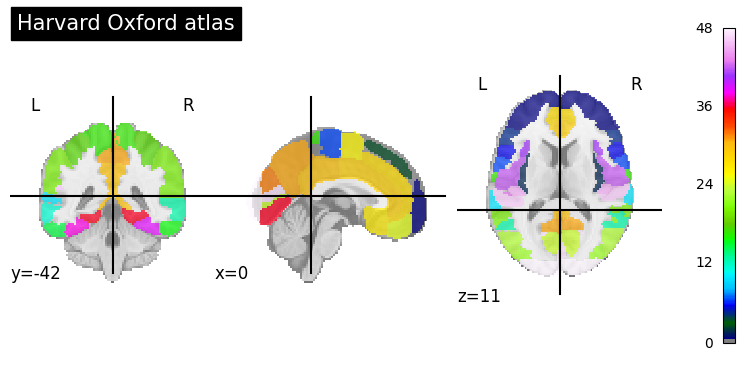

In [11]:
plot_roi(atlas.filename, title="Harvard Oxford atlas")

In [12]:
labels

['Background',
 'Frontal Pole',
 'Insular Cortex',
 'Superior Frontal Gyrus',
 'Middle Frontal Gyrus',
 'Inferior Frontal Gyrus, pars triangularis',
 'Inferior Frontal Gyrus, pars opercularis',
 'Precentral Gyrus',
 'Temporal Pole',
 'Superior Temporal Gyrus, anterior division',
 'Superior Temporal Gyrus, posterior division',
 'Middle Temporal Gyrus, anterior division',
 'Middle Temporal Gyrus, posterior division',
 'Middle Temporal Gyrus, temporooccipital part',
 'Inferior Temporal Gyrus, anterior division',
 'Inferior Temporal Gyrus, posterior division',
 'Inferior Temporal Gyrus, temporooccipital part',
 'Postcentral Gyrus',
 'Superior Parietal Lobule',
 'Supramarginal Gyrus, anterior division',
 'Supramarginal Gyrus, posterior division',
 'Angular Gyrus',
 'Lateral Occipital Cortex, superior division',
 'Lateral Occipital Cortex, inferior division',
 'Intracalcarine Cortex',
 'Frontal Medial Cortex',
 'Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)',
 'Subcallo

In [13]:
results = []

ref = load_img(X[0]) 
labels3d = resample_to_img(atlas.maps, ref, interpolation="nearest")

/tmp/ipykernel_3128090/2905952668.py:4: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  labels3d = resample_to_img(atlas.maps, ref, interpolation="nearest")
/tmp/ipykernel_3128090/2905952668.py:4: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  labels3d = resample_to_img(atlas.maps, ref, interpolation="nearest")


In [32]:
# from nilearn import plotting

# # Plot ROI mask as glass brain
# plotting.plot_roi(roi_mask, title="ROI Mask")

# # Or overlay ROI on anatomical/z-map
# plotting.plot_roi(roi_mask, bg_img=ref, title="ROI overlaid on reference")

# plotting.show()


In [ ]:
for idx, name in enumerate(atlas.labels):
    print(name)
    if idx == 0:  # 'Background'
        continue
    roi_mask = image.math_img(f"img == {idx}", img=labels3d) 
    if np.count_nonzero(roi_mask.get_fdata()) < 200:
        print(f"Skipping {name} because too small")
        continue
    clf = Decoder(
        estimator='svc', 
        mask=roi_mask,
        standardize=True,
        screening_percentile=25,   # univariate feature filter inside ROI
        cv=LeaveOneGroupOut(),
    )
    clf.fit(X, y, groups=groups)
    for label, scores in clf.cv_scores_.items():
        print(label, np.mean(scores))
    acc_per_class = [(label, np.mean(scores)) for label, scores in clf.cv_scores_.items()]
    classification_accuracy = np.mean(list(clf.cv_scores_.values()))
    results.append({"roi": name, "classification_accuracy": classification_accuracy, "per_class": acc_per_class})

roi_df_full = pd.DataFrame(results).sort_values("classification_accuracy", ascending=False)

In [15]:
roi_df_full

,roi,classification_accuracy,per_class
19,"Lateral Occipital Cortex, superior division",0.859496,"[(Control, 0.7586404441174558), (Food, 0.85612..."
34,Temporal Occipital Fusiform Cortex,0.833444,"[(Control, 0.7194048147576068), (Food, 0.80686..."
20,"Lateral Occipital Cortex, inferior division",0.831064,"[(Control, 0.6894560512625496), (Food, 0.81380..."
0,Frontal Pole,0.763470,"[(Control, 0.677625265866478), (Food, 0.817288..."
35,Occipital Fusiform Gyrus,0.763175,"[(Control, 0.6482232147803696), (Food, 0.74564..."
13,"Inferior Temporal Gyrus, temporooccipital part",0.753254,"[(Control, 0.656619066631017), (Food, 0.768199..."
39,Occipital Pole,0.752035,"[(Control, 0.6552947963938509), (Food, 0.78555..."
32,Lingual Gyrus,0.737612,"[(Control, 0.6474582935135805), (Food, 0.72623..."
28,Precuneous Cortex,0.734126,"[(Control, 0.679173512803744), (Food, 0.701697..."
11,"Middle Temporal Gyrus, temporooccipital part",0.731373,"[(Control, 0.6358952752546055), (Food, 0.67964..."


In [16]:
roi_df_full.to_csv("fasting_food_social_control_roi_classification.csv", index=False)

## Lets take Insular Cortex	 and do permutation test

In [14]:
atlas = datasets.fetch_atlas_harvard_oxford("cort-maxprob-thr25-2mm")
labels_img = atlas.maps
labels = atlas.labels  

[fetch_atlas_harvard_oxford] Dataset found in /home/anpa/nilearn_data/fsl


In [ ]:
ref = load_img(X[0]) 
labels3d = resample_to_img(atlas.maps, ref, interpolation="nearest")